In [1]:
from net.parse import *
from net import *

In [2]:
DELTA = 3
CONTEXT = 10

In [3]:
# Build dataset
trends = merge_on_date(parse_path(Path('../data/trends'))) # Parse trends data
stats = get_data() # Parse stats data
x_train, y_train, x_test, y_test, mean, std = build_data(trends, stats, DELTA, CONTEXT)

/Users/tudor/CS-Work/ML/P3/VFNN/src/net/parse/finance_parser.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  daily = yf.download(tickers='^SPX', start=start, end=end, interval='1d')
[*********************100%***********************]  1 of 1 completed


In [4]:
# Model Hyperparameters
HIDDEN = 32
INPUT_SIZE = 28 # Fixed
MLP_SIZE = (32, 1) # Has to end in 1
BATCH_SIZE = 32
STEPS = 1000
LR = 1e-2
LAMBDA_ = 1e-4

In [5]:
# Initialize
model = VFNN(HIDDEN, INPUT_SIZE, MLP_SIZE)

In [6]:

def hybrid_loss(preds, targets, alpha=0.7):
    return alpha * MAPE(preds, targets, mean[:, -2], std[:, -2]) + (1 - alpha) * RMSE(preds, targets)

Loss: 17.30584144592285 on step: 1
Loss: 23.14925765991211 on step: 101
Loss: 18.672714233398438 on step: 201
Loss: 17.993423461914062 on step: 301
Loss: 10.925811767578125 on step: 401
Loss: 22.378944396972656 on step: 501
Loss: 12.16507339477539 on step: 601
Loss: 8.148433685302734 on step: 701
Loss: 11.710824966430664 on step: 801
Loss: 9.638866424560547 on step: 901


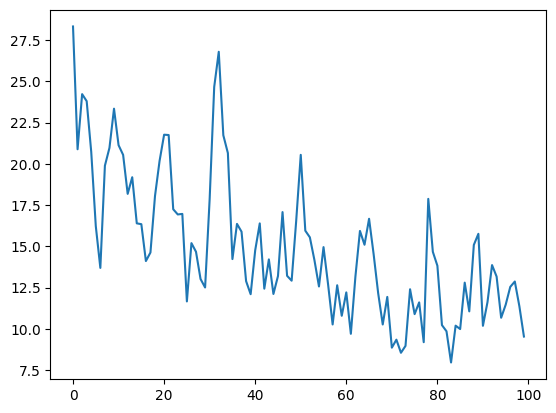

In [14]:
# Train
model.train()
lossi = adam(model, (lambda x, y: MAPE(x, y, mean[:, -2], std[:, -2])), x_train, y_train, LR, LAMBDA_, BATCH_SIZE, STEPS)

# Plot loss
from matplotlib import pyplot as plt
plt.plot(torch.tensor(lossi).view(-1, 10).mean(1))

In [15]:
model.eval()
vals = model.forward(x_train)
percents = (vals.flatten() * std[:, -2] + mean[:, -2]) / 1e4
targs = (y_train.flatten() * std[:, -2] + mean[:, -2]) / 1e4
loss = RMSE(percents, targs)
print(loss.item())
print(MAPE(vals, y_train, mean[:, -2], std[:, -2]).item())

0.011501449160277843
8.422723770141602


In [16]:
model.eval()
vals = model.forward(x_test)
percents = (vals.flatten() * std[:, -2] + mean[:, -2]) / 1e4
targs = (y_test.flatten() * std[:, -2] + mean[:, -2]) / 1e4
loss = RMSE(percents, targs)
print(loss.item())
print(MAPE(vals, y_test, mean[:, -2], std[:, -2]).item())

0.000560429529286921
24.912874221801758


Text(0.5, 1.0, 'Target Distribution (Unnormalized)')

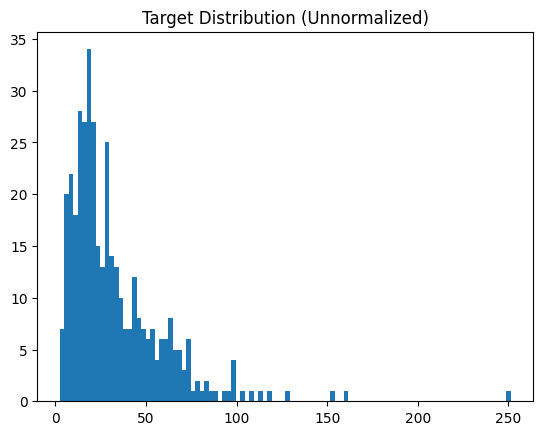

In [17]:
plt.hist((targs * 1e4).numpy(), bins=100)
plt.title("Target Distribution (Unnormalized)")


Text(0.5, 1.0, 'Percent Distribution (Unnormalized)')

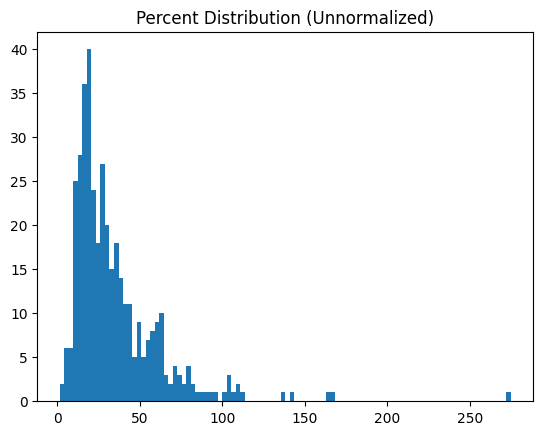

In [18]:
plt.hist((percents*1e4).detach().numpy(), bins=100)
plt.title("Percent Distribution (Unnormalized)")

Text(0, 0.5, 'Absolute Error')

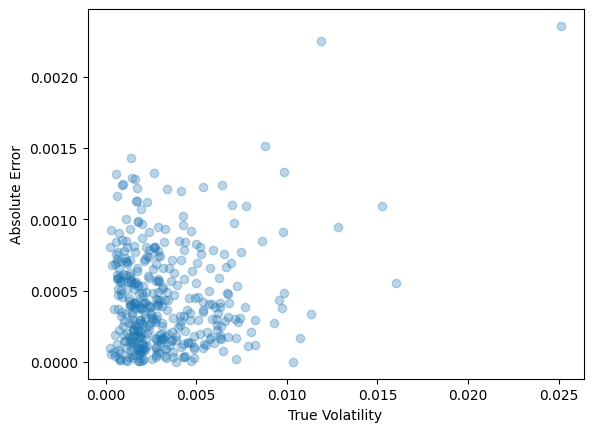

In [19]:
plt.scatter(targs.numpy(), (percents.detach() - targs).abs().numpy(), alpha=0.3)
plt.xlabel("True Volatility")
plt.ylabel("Absolute Error")


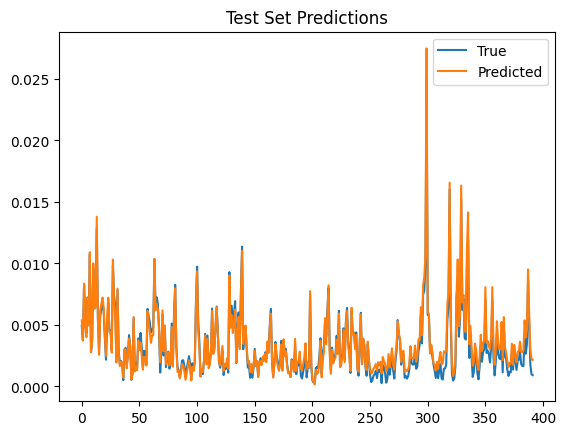

In [20]:
plt.plot(targs.detach(), label="True")
plt.plot(percents.detach(), label="Predicted")
plt.title("Test Set Predictions")
plt.legend()


In [21]:
bins = [0, 0.001, 0.003, 0.01, 0.02, 1.0]
for i in range(len(bins)-1):
    mask = (targs >= bins[i]) & (targs < bins[i+1])
    bin_mape = torch.mean(torch.abs((percents[mask] - targs[mask]) / targs[mask]))
    print(f"MAPE for {bins[i]}–{bins[i+1]}: {bin_mape.item()*100:.2f}%")


MAPE for 0–0.001: 83.25%
MAPE for 0.001–0.003: 23.43%
MAPE for 0.003–0.01: 8.47%
MAPE for 0.01–0.02: 5.92%
MAPE for 0.02–1.0: 9.37%


In [22]:
mask = targs >= 0.003
filtered_mape = torch.mean(torch.abs((percents[mask] - targs[mask]) / targs[mask]))
print("Filtered MAPE (vol ≥ 0.003):", filtered_mape.item() * 100)


Filtered MAPE (vol ≥ 0.003): 8.364875614643097
